In [24]:
#from tqdm import tqdm
import torch
from torch import nn
import matplotlib.pyplot as plt
import utils

#### Generate the training and test data first.

In [25]:
X = torch.arange(1,10.1,0.5)
X = X.unsqueeze(dim = 1)
weight = 0.3
bias = 0.9
y = weight * X + bias
y

tensor([[1.2000],
        [1.3500],
        [1.5000],
        [1.6500],
        [1.8000],
        [1.9500],
        [2.1000],
        [2.2500],
        [2.4000],
        [2.5500],
        [2.7000],
        [2.8500],
        [3.0000],
        [3.1500],
        [3.3000],
        [3.4500],
        [3.6000],
        [3.7500],
        [3.9000]])

In [26]:
train_split = int(0.6 * len(X))
train_X, train_y = X[:train_split], y[:train_split]
test_X, test_y = X[train_split:], y[train_split:]
test_X, test_y

(tensor([[ 6.5000],
         [ 7.0000],
         [ 7.5000],
         [ 8.0000],
         [ 8.5000],
         [ 9.0000],
         [ 9.5000],
         [10.0000]]),
 tensor([[2.8500],
         [3.0000],
         [3.1500],
         [3.3000],
         [3.4500],
         [3.6000],
         [3.7500],
         [3.9000]]))

#### Instantiate PyTorch's Linear Regression Model instead of a custom model.

In [27]:
class Linear_Regression(nn.Module):

    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(in_features=1,
                                      out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        calculates and returns the output of the neural network
        """
        output = self.input_layer(x)
        return output

torch.manual_seed(42)
lin_reg_model = Linear_Regression()
lin_reg_model

Linear_Regression(
  (input_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [28]:
lin_reg_model.state_dict()

OrderedDict([('input_layer.weight', tensor([[0.7645]])),
             ('input_layer.bias', tensor([0.8300]))])

#### Set up device.
It is seen above that the model parameters are not on CUDA device.

In [29]:
# check the current device on which the model's parameters were created.
next(lin_reg_model.parameters()).device

device(type='cpu')

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Send the model and the input to GPU.


In [31]:
lin_reg_model.to(device=device)
next(lin_reg_model.parameters()).device

device(type='cuda', index=0)

In [32]:
lin_reg_model.state_dict()

OrderedDict([('input_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('input_layer.bias', tensor([0.8300], device='cuda:0'))])

In [33]:
train_X = train_X.to(device = device)
train_y = train_y.to(device=device)
test_X = test_X.to(device = device)
test_y = test_y.to(device=device)
train_X, test_X

(tensor([[1.0000],
         [1.5000],
         [2.0000],
         [2.5000],
         [3.0000],
         [3.5000],
         [4.0000],
         [4.5000],
         [5.0000],
         [5.5000],
         [6.0000]], device='cuda:0'),
 tensor([[ 6.5000],
         [ 7.0000],
         [ 7.5000],
         [ 8.0000],
         [ 8.5000],
         [ 9.0000],
         [ 9.5000],
         [10.0000]], device='cuda:0'))

#### Predictions before the model is trained.

In [34]:
# set the NN to evaluation mode
lin_reg_model.eval()

# predictions = lin_reg_model(test_X)
# using context manager to make inference
with torch.inference_mode():
    predictions = lin_reg_model(test_X)

predictions

tensor([[5.7995],
        [6.1818],
        [6.5640],
        [6.9463],
        [7.3286],
        [7.7109],
        [8.0931],
        [8.4754]], device='cuda:0')

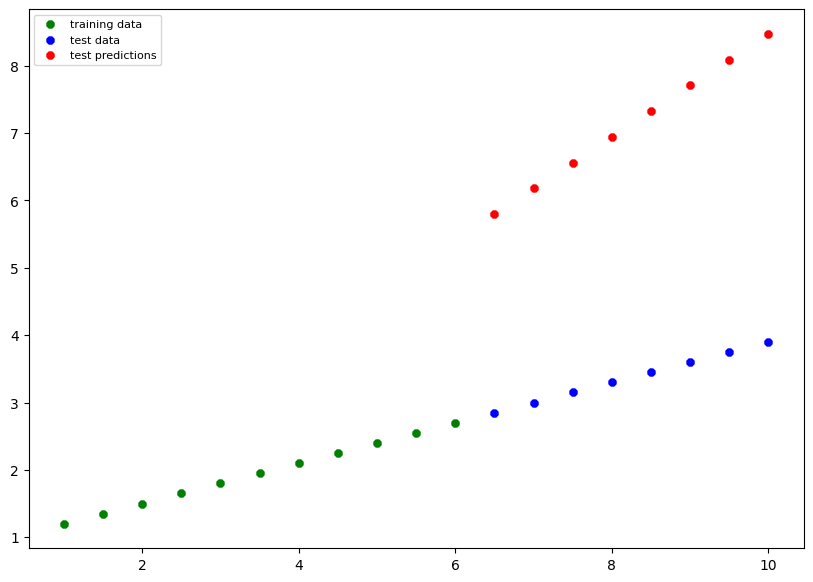

In [35]:
# if context manager was not used while making predictions above
#utils.plot_predictions(train_X, train_y, test_X, test_y, predictions.detach().numpy())

# if context manager used above
utils.plot_predictions(train_X.to("cpu"), train_y.to("cpu"), test_X.to("cpu"), test_y.to("cpu"), predictions.to("cpu"))

#### Train the model
One way to measure how bad the predictions are is to use the loss functions. `torch.nn` has many pre-defined loss functions such as L1 loss, L2 loss, CrossEntropy loss, etc. In order to train a model based on how bad the current predictions are according to a loss function, we need an optimizer that tries to minimize the error in terms of the loss function. torch has `torch.optim` module that makes many optimizers such as `torch.optim.SGD` available.

Set up a loss function.

In [36]:
loss_func = nn.MSELoss()
loss_func

MSELoss()

Set up an optimizer.

In [37]:
optimizer = torch.optim.SGD(params = lin_reg_model.parameters(),
                             lr = 0.0001)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Set up the training and testing loop.

In [38]:
torch.manual_seed(42)

epochs = 1000
epoch_ctr = []
training_loss_list = []
test_loss_list = []

# for each pass of the training data
for epoch in range(0, epochs):        

    ###### TRAINING SECTION
    # set the model to training mode
    lin_reg_model.train()

    # make predictions for all training data
    predictions = lin_reg_model(train_X)
    
    # calculate the training loss
    training_loss = loss_func(predictions, train_y)
    
    # clear the garbage gradient value
    optimizer.zero_grad()
    
    # calculate the gradients using backpropagation
    training_loss.backward()
    
    # update model parameters using the calculated gradients
    optimizer.step()

    ###### EVALUATION SECTION

    # set the model to evaluation mode
    # this ensures that any calculation that is not needed in the test mode is skipped
    # such as batch norm or dropout operations
    lin_reg_model.eval()
    
    # evaluate the model after the parameter update
    if epoch % 50 == 0:

        # inference mode ensures that the gradients are not tracked within this with loop
        with torch.inference_mode():

            # make predictions for test data
            test_predictions = lin_reg_model(test_X)

            # calculate the loss
            test_loss = loss_func(test_predictions, test_y)
            print("\nEPOCH ", epoch, " | Training loss: ",training_loss.detach().item()," | Test loss: ", test_loss.item())
            #print(lin_reg_model.state_dict())
            # store the training and test loss for the plot
            epoch_ctr.append(epoch)
            training_loss_list.append(training_loss.to("cpu").item())
            test_loss_list.append(test_loss.to("cpu").item())





EPOCH  0  | Training loss:  2.9602925777435303  | Test loss:  14.353410720825195

EPOCH  50  | Training loss:  2.1675968170166016  | Test loss:  10.664352416992188

EPOCH  100  | Training loss:  1.5875158309936523  | Test loss:  7.942463397979736

EPOCH  150  | Training loss:  1.1630213260650635  | Test loss:  5.931575775146484

EPOCH  200  | Training loss:  0.8523814678192139  | Test loss:  4.44376277923584

EPOCH  250  | Training loss:  0.6250580549240112  | Test loss:  3.341099739074707

EPOCH  300  | Training loss:  0.4587043225765228  | Test loss:  2.5223076343536377

EPOCH  350  | Training loss:  0.3369661271572113  | Test loss:  1.912976622581482

EPOCH  400  | Training loss:  0.24787767231464386  | Test loss:  1.4584077596664429

EPOCH  450  | Training loss:  0.18268074095249176  | Test loss:  1.1183485984802246

EPOCH  500  | Training loss:  0.1349669098854065  | Test loss:  0.8631631731987

EPOCH  550  | Training loss:  0.10004672408103943  | Test loss:  0.6710070371627808



As seen above, training for more epochs reduces the test loss in general, heading toward 0. However, over-training will cause the test loss to increase if the learning rate is not gradually reduced.

#### Plots

Prediction vs. Ground Truth

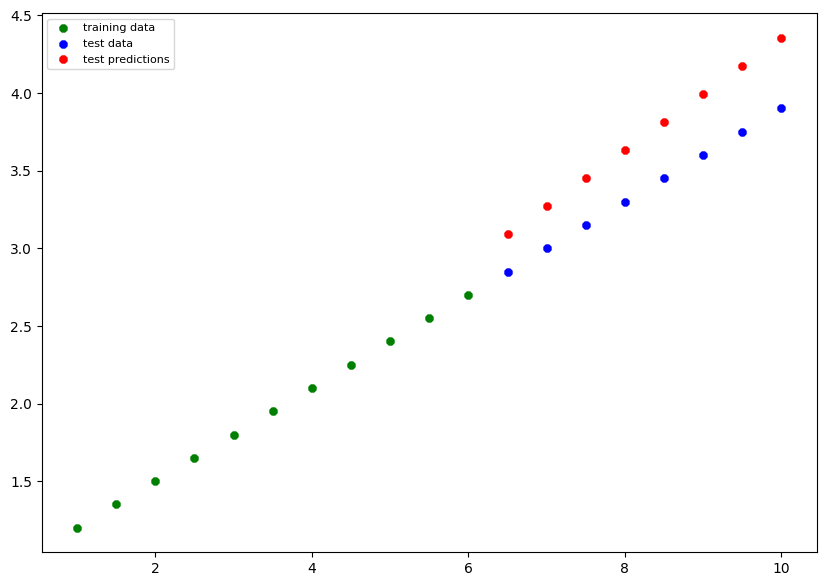

In [39]:
# plot the predictions vs the ground truth at the end
utils.plot_predictions(train_X.to("cpu"), train_y.to("cpu"), test_X.to("cpu"), test_y.to("cpu"), test_predictions.to("cpu"))

As seen above, our model has learned a decent estimation of the simple linear regression parameters such that the predictions (in red) are much closed to the ground truth (in blue) than from where we started. 

Training Loss vs Test Loss

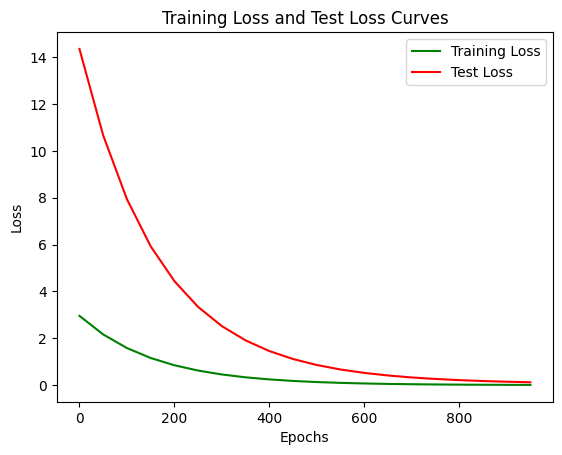

In [40]:
plt.plot(epoch_ctr, training_loss_list, "g", label = "Training Loss")
plt.plot(epoch_ctr, test_loss_list, "r", label = "Test Loss")
plt.title("Training Loss and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

As seen above, the training and test loss values gradually decrease over the epochs.

#### Save the trained model so as to re-use later.
- `torch.save()` saves a PyTorch object in .pkl format
    - This includes a `torch.nn.Module` object (a NN in torch) and a `torch.optim.SGD` object.
- `torch.load()` - loads a saved PyTorch object.
- `torch.nn.Module.load_state_dict()` allows a saved model parameters to be loaded to a torch NN.

In [51]:
lin_reg_model.state_dict()

OrderedDict([('input_layer.weight', tensor([[0.3585]], device='cuda:0')),
             ('input_layer.bias', tensor([0.7383], device='cuda:0'))])

In [48]:
path_to_save_model = "saved_params\lin_reg_model_params.pth"

# save the model and optimizer's state dicts
torch.save(lin_reg_model.state_dict(), path_to_save_model)

Load a saved model.

In [52]:
new_model = Linear_Regression().to(device=device)
new_model.state_dict() 


OrderedDict([('input_layer.weight', tensor([[-0.4869]], device='cuda:0')),
             ('input_layer.bias', tensor([0.5873], device='cuda:0'))])

In [53]:
new_model.load_state_dict(torch.load(path_to_save_model))

<All keys matched successfully>

#### Evaluate the loaded model.
New predictions can be made using this loaded model.

In [54]:
# predict using both models to compare side-by-side
lin_reg_model.eval()
new_model.eval()
with torch.inference_mode():
    print(lin_reg_model(test_X))
    print(new_model(test_X))

tensor([[3.0686],
        [3.2478],
        [3.4271],
        [3.6063],
        [3.7856],
        [3.9648],
        [4.1441],
        [4.3233]], device='cuda:0')
tensor([[3.0686],
        [3.2478],
        [3.4271],
        [3.6063],
        [3.7856],
        [3.9648],
        [4.1441],
        [4.3233]], device='cuda:0')


In [55]:
lin_reg_model(test_X) == new_model(test_X)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

As seen above, both, the original model and the saved model, provide the same predictions.